In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pyplot as plt
# DeepMoD stuff
from deepymod import DeepMoD
from deepymod.model.func_approx import NN
from deepymod.model.library import Library1D
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from deepymod.data import Dataset
from deepymod.data.burgers import BurgersDelta

#if torch.cuda.is_available():
#    device = 'cuda'
#else:
device = 'cpu'

# Settings for reproducibility
np.random.seed(44)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [ ]:


# Making dataset

noise = 0.1
A = 1
v = 0.25

runs = 1
dataset = Dataset(BurgersDelta, A=A, v=v)

x = np.linspace(-4.1, 4.1, 120) 
t = np.linspace(0.1, 1.1, 100) 
t_grid, x_grid = np.meshgrid(t, x, indexing='ij')
X, y = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=noise, random=False, normalize=False)
X.shape

xt = X.reshape(x_grid.shape[0],x_grid.shape[1],2)
yt = y.reshape(x_grid.shape[0],x_grid.shape[1])

for n_x in np.arange(1):
    number_of_samples = 20
    ytrain = np.empty([yt.shape[0],number_of_samples])
    xtrain = np.empty([xt.shape[0],number_of_samples,xt.shape[2]])
    for i in np.arange(yt.shape[0]):
        idx = np.random.permutation(yt.shape[1])
        ytrain[i,:] = yt[i,idx][:number_of_samples]
        xtrain[i,:,0] = xt[i,idx,0][:number_of_samples]
        xtrain[i,:,1] = xt[i,idx,1][:number_of_samples]
    xtrain_b = np.transpose(xtrain,axes=(1,0,2))
    ytrain_b = ytrain.T
    X = torch.tensor(xtrain_b.reshape(-1,2), dtype=torch.float32, requires_grad=True)
    y = torch.tensor(ytrain_b.reshape(-1,1), dtype=torch.float32)
    print(y.shape)
    X, y = X.to(device), y.to(device)
    network = NN(2, [30, 30, 30, 30], 1)
    library = Library1D(poly_order=3, diff_order=3) # Library function
    estimator = Threshold(0.2) # Sparse estimator 
    constraint = LeastSquares() # How to constrain
    model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model

    sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=500, delta=1e-7) # in terms of write iterations
    optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) # Defining optimizer

    train(model, X, y, optimizer, sparsity_scheduler, log_dir='runs/revision_3order_10noise'+str(n_x), split=0.8, write_iterations=25, max_iterations=100000, delta=1e-4, patience=500) 
    print(model.constraint_coeffs(sparse=True, scaled=True))

torch.Size([2000, 1])
 12575  MSE: 5.77e-04  Reg: 1.63e-05  L1: 5.51e+00 

In [2]:
from deepymod.analysis import load_tensorboard

In [20]:
df_deriv = load_tensorboard('runs/revision_random_grid_4deriv_10noise0')

In [10]:
df_poly = load_tensorboard('runs/revision_3order_10noise0')

In [11]:
df_poly['coeffs_output_0_coeff_2'].iloc[-1]



0.9163229465484619

In [16]:
df_poly['coeffs_output_0_coeff_5'].iloc[-1]

-0.6041955947875977

In [18]:
xi_plot = np.zeros((20,3))

In [44]:
xi_plot[:,0] = [0,0,0.92,0,0,0,-0.6,0,0,0,0,0,0,0,0,0,0,0,0,0]
xi_plot[:,1] = [0,0,df_deriv['coeffs_output_0_coeff_2'].iloc[-1],0,0,0,df_deriv['coeffs_output_0_coeff_6'].iloc[-1],0,0,0,0,0,0,0,0,0,0,0,0,0]
xi_plot[:,2] = [0,0,df_poly['coeffs_output_0_coeff_2'].iloc[-1],0,0,0,df_poly['coeffs_output_0_coeff_5'].iloc[-1],0,0,0,0,0,0,0,0,0,0,0,0,0]

In [45]:
import seaborn as sns

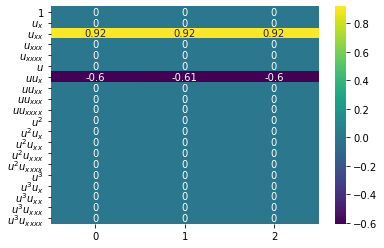

In [47]:
sns.color_palette("viridis")
sns.heatmap(xi_plot, annot=True, cmap="viridis",yticklabels=['1','$u_x$','$u_{xx}$','$u_{xxx}$','$u_{xxxx}$','$u$','$u u_x$','$u u_{xx}$','$u u_{xxx}$','$u u_{xxxx}$','$u^2$','$u^2 u_x$','$u^2 u_{xx}$','$u^2 u_{xxx}$','$u^2 u_{xxxx}$','$u^3$','$u^3 u_x$','$u^3 u_{xx}$','$u^3 u_{xxx}$','$u^3 u_{xxxx}$'])
plt.savefig('values.pdf')

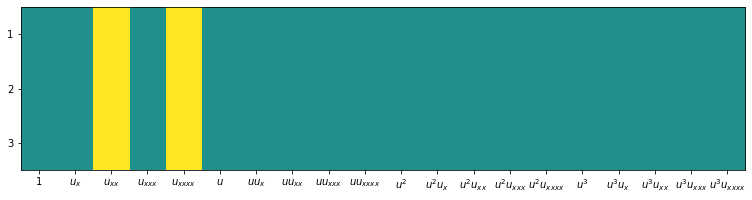

<Figure size 432x288 with 0 Axes>

In [82]:
plt.figure(figsize=(20,3))
plt.imshow(xi_plot.T,aspect=1.5, vmin=-1, vmax=1, interpolation='none')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],['1','$u_x$','$u_{xx}$','$u_{xxx}$','$u_{xxxx}$','$u$','$u u_x$','$u u_{xx}$','$u u_{xxx}$','$u u_{xxxx}$','$u^2$','$u^2 u_x$','$u^2 u_{xx}$','$u^2 u_{xxx}$','$u^2 u_{xxxx}$','$u^3$','$u^3 u_x$','$u^3 u_{xx}$','$u^3 u_{xxx}$','$u^3 u_{xxxx}$'])
plt.yticks([0,1,2],[1,2,3])
plt.show()
plt.savefig('values.pdf')

In [ ]:
for n_x in np.array([4,6,8,10,12,14,16]):
    for run in np.arange(runs):
        
        number_of_samples = n_x * 100
        idx = np.random.permutation(y.shape[0])
        X = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
        y = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)
        X, y = X.to(device), y.to(device)
        network = NN(2, [30, 30, 30, 30], 1)
        library = Library1D(poly_order=2, diff_order=3) # Library function
        estimator = Threshold(0.2) # Sparse estimator 
        constraint = LeastSquares() # How to constrain
        model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model

        sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=500, delta=1e-7) # in terms of write iterations
        optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) # Defining optimizer

        train(model, X, y, optimizer, sparsity_scheduler, log_dir='runs/rand'+str(n_x), split=0.8, write_iterations=25, max_iterations=100000, delta=1e-4, patience=500) 
        print(model.constraint_coeffs(sparse=True, scaled=True))

 28500  MSE: 8.57e-06  Reg: 4.27e-06  L1: 1.41e+00 Algorithm converged. Writing model to disk.
[tensor([[ 0.0000],
        [ 0.0000],
        [ 0.6382],
        [ 0.0000],
        [ 0.0000],
        [-0.7670],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]], device='cuda:0', grad_fn=<MulBackward0>)]
 99975  MSE: 6.56e-06  Reg: 9.61e-07  L1: 3.85e+00 Algorithm converged. Writing model to disk.
[tensor([[ 7.9732e-04],
        [-3.5464e-02],
        [ 6.7906e-01],
        [ 6.0199e-02],
        [ 2.7272e-01],
        [-8.8315e-01],
        [-3.8879e-01],
        [-2.4706e-01],
        [-4.5990e-01],
        [ 2.9216e-01],
        [ 2.1149e-01],
        [ 3.2241e-01]], device='cuda:0', grad_fn=<MulBackward0>)]
 36300  MSE: 1.05e-05  Reg: 4.87e-06  L1: 1.46e+00 